## Importando as bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
import seaborn as sns
import itertools  #loops e interações
import statsmodels.api as sm  #modelo estatístico
from datetime import datetime
from statsmodels.graphics.tsaplots import month_plot, quarter_plot  #tsa - time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf  #calcular função de autocorrelação 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #gerar gráfico da função de autocorrelação e autocorr. parcial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff  #diff - diferenciação da série
from statsmodels.tsa.arima.model import ARIMA #Incluido por mim para tentar solucuonar o erro na célula 46
#from statsmodels.tsa.arima_model import ARIMA  #calculo do modelo ARIMA
#from statsmodels.tsa.arima_model import ARMA  #calculo do modelo ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as sct
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error  #métrica erro médio absoluto
from sklearn.metrics import mean_squared_error  #métrica erro médio quadrático
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima  #autoarima para fazer a busca automática dos parâmetros do modelo
from pmdarima.arima import ADFTest  #test Dick Fuller para avaliar a estacionariedade da série
from statsmodels.tsa.statespace.sarimax import SARIMAX #cáculo de modelo sazonal e com variáveis exógenas
from xgboost import XGBRegressor
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

### Importando a base de Acessos e colocando o campo 'Data' como o index

In [4]:
df = pd.read_csv('Acessos_Banda_Larga_Fixa_Total_2011_2022.csv',index_col='Data',parse_dates=True)
df.index.freq = 'MS'
df.head(5)

,Acessos
Data,
2011-01-01,14508818
2011-02-01,14764348
2011-03-01,15058564
2011-04-01,15260984
2011-05-01,15486330


In [5]:
df.shape

(139, 1)

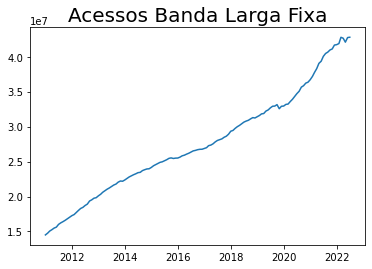

In [7]:
#Visualização dos dados
plt.title('Acessos Banda Larga Fixa', size=20)
plt.plot(df);

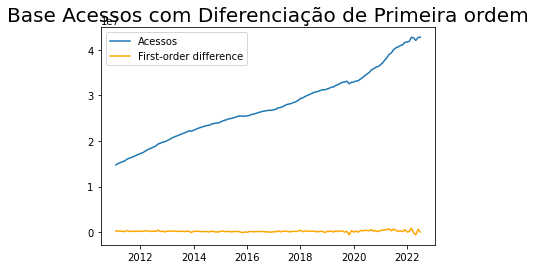

In [8]:
# Comportamento da diferenciação da série

df['Acessos_Diff'] = df['Acessos'].diff(periods=1)
df = df.dropna()

# Plot
plt.title('Base Acessos com Diferenciação de Primeira ordem', size=20)
plt.plot(df['Acessos'], label='Acessos')
plt.plot(df['Acessos_Diff'], label='First-order difference', color='orange')
plt.legend();

In [9]:
#Teste de estacionariedade série original
# p valor = 0.99 --> indica que a série é não estacionária
adfuller(df["Acessos"])

(0.8019904123215388,
 0.9916682291661889,
 3,
 134,
 {'1%': -3.480118600110386,
  '5%': -2.8833618426136196,
  '10%': -2.578407034974382},
 3327.211004451594)

In [10]:
#Teste de estacionariedade série diferenciada
adfuller(df["Acessos_Diff"])

(-2.9720057964376085,
 0.03759270457919257,
 14,
 123,
 {'1%': -3.4846672514209773,
  '5%': -2.8853397507076006,
  '10%': -2.5794629869786503},
 3324.4816636309783)

In [11]:
#Cálculo da autocorrelação
acf_values = acf(df['Acessos_Diff'])
np.round(acf_values,2)

array([ 1.  ,  0.08,  0.19,  0.32,  0.17,  0.11,  0.13,  0.14,  0.15,
        0.06,  0.09,  0.22, -0.03,  0.15, -0.02, -0.02, -0.03, -0.06,
       -0.05, -0.02, -0.14, -0.03])

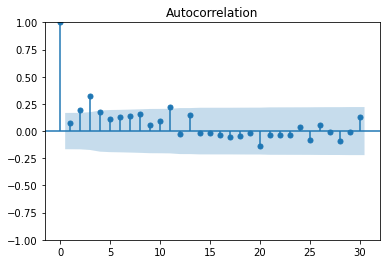

In [12]:
#Gráfico da autocorrelação
plot_acf(df['Acessos_Diff'], lags=30);

In [13]:
#Cálculo da autocorrelação parcial
pacf_values = pacf(df['Acessos_Diff'])
np.round(pacf_values,2)

array([ 1.  ,  0.08,  0.19,  0.31,  0.14,  0.  , -0.02,  0.04,  0.11,
       -0.01, -0.01,  0.16, -0.1 ,  0.07, -0.17, -0.09, -0.11, -0.06,
       -0.03,  0.02, -0.12, -0.02])

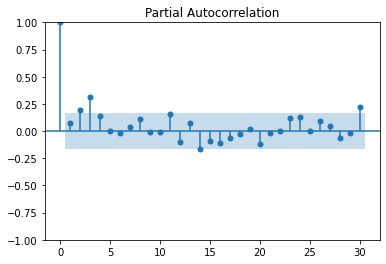

In [14]:
#Gráfico da autocorrelação parcial
plot_pacf(df['Acessos_Diff'], lags=30);

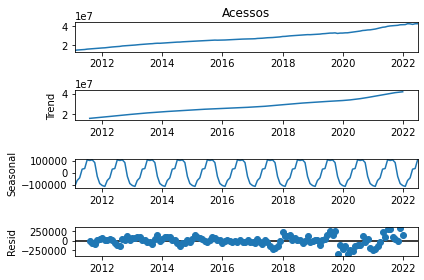

In [15]:
#Decomposição sazonal para ver os componentes
result = seasonal_decompose(df['Acessos'], 
                            model ='additive')
result.plot();

In [16]:
#Ajustar auto arima para a base
stepwise_fit = auto_arima(df['Acessos'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3464.098, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3460.292, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3462.496, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3462.491, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3464.229, Time=0.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3464.336, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3463.081, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3461.629, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3461.641, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3463.597, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=3461.659, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.003 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  138
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1729.146
Date:                            Wed, 28 Sep 2022   AIC                           3460.292
Time:                                    10:53:56   BIC                           3463.120
Sample:                                02-01-2011   HQIC                          3461.441
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.466e+10   2.81e+09     19.423      0.000    4.91e+10    6.02e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):               346.13
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):              17.89   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#Tamanho da Base
df.shape

(138, 2)

In [18]:
#Separa a base em treino e teste
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:] # Deixa 12 meses para teste

In [19]:
#Ajusta um modelo SARIMAX(0, 1, 0)x(0, 1, 0, 12) na base de treinamento
model = SARIMAX(train['Acessos'], 
                order = (0, 1, 0), 
                seasonal_order =(0, 1, 0, 12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Acessos   No. Observations:                  126
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1534.556
Date:                            Wed, 28 Sep 2022   AIC                           3071.112
Time:                                    10:54:29   BIC                           3073.839
Sample:                                02-01-2011   HQIC                          3072.218
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.259e+10    1.8e+09     18.065      0.000    2.91e+10    3.61e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):               249.96
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               9.40   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Data'>

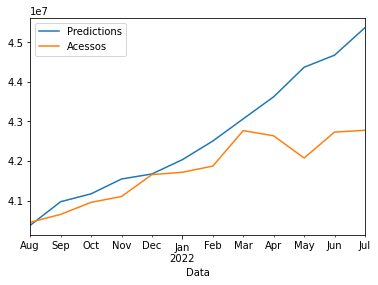

In [20]:
#Predição do modelo ARIMA na base de teste
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
predictions.plot(legend = True)
test['Acessos'].plot(legend = True)

In [21]:
#Cálculo da acurácia das previsões (raiz do erro medio quadratico)
rmse(test["Acessos"], predictions).round(2)

1213500.28

In [22]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

In [23]:
print((metrics.mean_absolute_percentage_error(test["Acessos"], predictions)*100).round(2))

2.0


In [24]:
print(metrics.mean_absolute_percentage_error(test["Acessos"], predictions)*100)

1.9965728897894077


#### Escolha automática de parâmetros por meio do auto-arima

In [26]:
# Importando a base de Acessos e colocando o campo 'Data' como o index
df = pd.read_csv('Acessos_Banda_Larga_Fixa_Total_2011_2022.csv',index_col='Data',parse_dates=True)
df.index.freq = 'MS'
df.head(5)

,Acessos
Data,
2011-01-01,14508818
2011-02-01,14764348
2011-03-01,15058564
2011-04-01,15260984
2011-05-01,15486330


<AxesSubplot:xlabel='Data'>

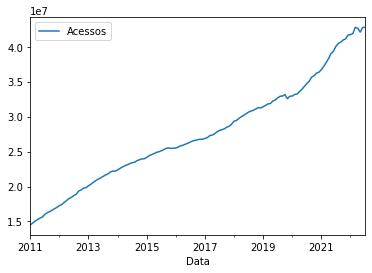

In [27]:
#Visualizando os dados
df.plot()

In [28]:
#Teste de estacionariedade da série
adfuller(df)

(0.8016030050619128,
 0.9916619995144154,
 3,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 3353.6436643188135)

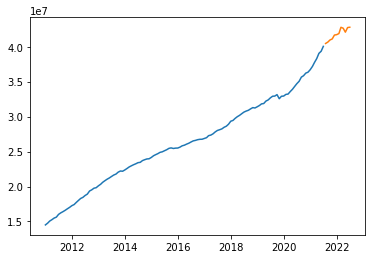

In [30]:
#Separação da base em treino e teste
#Deixa só 12 meses para teste para no treino pegar mais período da covid.

train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:] # Deixa 12 meses para teste

plt.plot(train)
plt.plot(test)

In [31]:
#Especificação do modelo ARIMA
arima_model=auto_arima(train, start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0,
                      D=1, start_Q=5, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=True, error_action="warn",
                      trace=True, suppress_warnings=True, stepwise=True,
                      random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,5)[12]             : AIC=3104.445, Time=2.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3097.523, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3100.176, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3100.212, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3101.375, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3100.117, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3100.331, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3098.662, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3098.692, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3093.685, Time=0.43 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3094.922, Time=0.86 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3094.915, Time=0.91 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3104.085, Time=0.29 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=3105.632, Time=0.10 sec
 ARIMA(1,1,2)(0,1,0

In [32]:
#Resumo do modelo
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               -1543.843
Date:                             Wed, 28 Sep 2022   AIC                           3093.685
Time:                                     10:56:04   BIC                           3101.894
Sample:                                 01-01-2011   HQIC                          3097.017
                                      - 07-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.013     77.267      0.000       0.975       1.025
ma.L1         -0.9465      0.014    -66.850      0.000      -0.974      -0.919
sigma2      3.675e+10   3.93e-14   9.35e+23      0.000    3.67e+10    3.67e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.67   Jarque-Bera (JB):               261.54
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               8.76   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.84e+39. Standard errors may be unstable.
"""

In [33]:
#Prevendo valores na base de teste
prediction=pd.DataFrame(arima_model.predict(n_periods=12), index=test.index)
prediction.columns = ['predicted_acessos']
prediction

,predicted_acessos
Data,
2021-08-01,4.050924e+07
2021-09-01,4.123860e+07
2021-10-01,4.157068e+07
2021-11-01,4.207744e+07
2021-12-01,4.233788e+07
2022-01-01,4.283131e+07
2022-02-01,4.343495e+07
2022-03-01,4.412876e+07
2022-04-01,4.481840e+07


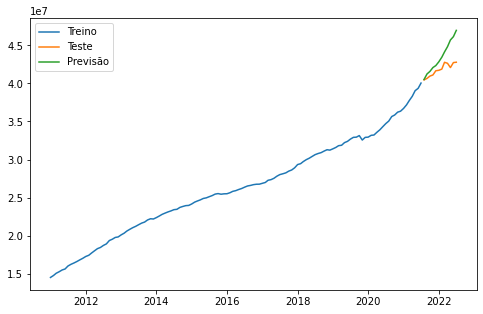

In [34]:
#Visualização das previsões
plt.figure(figsize=(8,5))
plt.plot(train, label="Treino")
plt.plot(test, label="Teste")
plt.plot(prediction, label="Previsão")
plt.legend(loc="upper left")
plt.show()

In [35]:
#Cálculo da acurácia das previsões (raiz do erro medio quadratico)
rmse(test["Acessos"], prediction["predicted_acessos"]).round(2)

2134004.26

In [36]:
print((metrics.mean_absolute_percentage_error(test["Acessos"], prediction["predicted_acessos"])*100).round(2))

4.01


In [34]:
# Resultados Alcançados

# Ajuste Manual com Sarimax
# train = df.iloc[:len(df)-12]   91%
# test = df.iloc[len(df)-12:]     9%
# n_periods=12 
# acurácia = 1213500.2779354854  3% de erro

# Auto-Arima
# train = df.iloc[:len(df)-12]   91%
# test = df.iloc[len(df)-12:]     9%
# n_periods=12 
# acurácia = 2134011.8756925566  5% de erro

# Auto-Arima
# train=df[:110] 80%
# test=df[-29:]  20%
# n_periods=29 
# acurácia = 3841679.646264531  9% de erro